# 第二章：谐波 Harmonics

在这章中我们会介绍几种新的波形以及他们的频谱，理解频谱的谐波结构（ harmonic structure ），也就是构成整个频谱的正弦信号的集合。
> In this chapter I present several new waveforms; we will look at their spectrums to understand their harmonic structure, which is the set of sinusoids they are made up of.

另外，还会介绍在数字信号处理中的另一个重要的概念：混叠（ aliasing ）。 然后我会解释一下 Spectrum 是如何工作的。
> I’ll also introduce one of the most important phenomena in digital signal processing: aliasing. And I’ll explain a little more about how the Spectrum class works.

这章的代码 chap02.ipynb 可以在本书的 代码库 中找到，你也可以在 http://tinyurl.com/thinkdsp02 查看。
> The code for this chapter is in chap02.ipynb, which is in the repository for this book (see Section 0.2). You can also view it at http://tinyurl.com/ thinkdsp02.

In [1]:
# Get thinkdsp.py
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
        
import thinkdsp

## 2.1 三角波 Triangle waves

正弦信号仅包含一个频率分量，因此它的频谱只有一个峰值。大多数复杂的信号，如小提琴声，它们的DFT会包含多个峰值。这一小节，我们来研究这些波形和他们的频谱之间的关系。
> A sinusoid contains only one frequency component, so its spectrum has only one peak. More complicated waveforms, like the violin recording, yield DFTs with many peaks. In this section we investigate the relationship between waveforms and their spectrums.

我们先从三角波开始，图2.1 展示了一个200Hz的三角波，它的波形看起来像是把正弦信号拉直了。
> I’ll start with a triangle waveform, which is like a straight-line version of a sinusoid. Figure 2.1 shows a triangle waveform with frequency 200 Hz.

![图2.1： 200Hz的三角波波形图](figs/thinkdsp006.png)

你可以使用 thinkdsp.TriangleSignal 来生成一个三角波:
> To generate a triangle wave, you can use thinkdsp.TriangleSignal:

```
class TriangleSignal(thinkdsp.Sinusoid):

    def evaluate(self, ts):
        cycles = self.freq * ts + self.offset / PI2
        frac, _ = np.modf(cycles)
        ys = np.abs(frac - 0.5)
        ys = normalize(unbias(ys), self.amp)
        return ys
```

TriangleSignal 继承自 Sinusoid ， 因此它同样包含 freq ， amp ， offset 三个属性。
> TriangleSignal inherits __init__ from Sinusoid, so it takes the same arguments: freq, amp, and offset.

不同在于它复写了 evaluate 。其中 ts 依然是采样点的时间，我们来看看这个 evaluate 是如何产生 三角波的：
> The only difference is evaluate. As we saw before, ts is the sequence of sample times where we want to evaluate the signal.
> There are many ways to generate a triangle wave. The details are not impor- tant, but here’s how evaluate works:

* cycles 表示从采样点的循环数。 np.modf 把它的小数部分提取出来放到 frac 中，它的整数部分 被丢弃了 [1]
> cycles is the number of cycles since the start time. np.modf splits the number of cycles into the fraction part, stored in frac, and the integer part, which is ignored 1.
* frac 现在是一个给定频率的0 ~ 1变化的斜坡信号，将它减去0.5会使其范围变到$-0.5 ~ 0.5$。然后取绝对值后， 它的值就成了从0增加到0.5，再从0.5减小到0
> frac is a sequence that ramps from 0 to 1 with the given frequency. Subtracting 0.5 yields values between -0.5 and 0.5. Taking the absolute value yields a waveform that zig-zags between 0.5 and 0.
* unbias 会把整个信号向下移动，使其相对于y轴居中，然后 normalize 将信号的幅度放大到 amp 。
> unbias shifts the waveform down so it is centered at 0; then normalize scales it to the given amplitude, amp.

产生 图2.1 的代码如下:

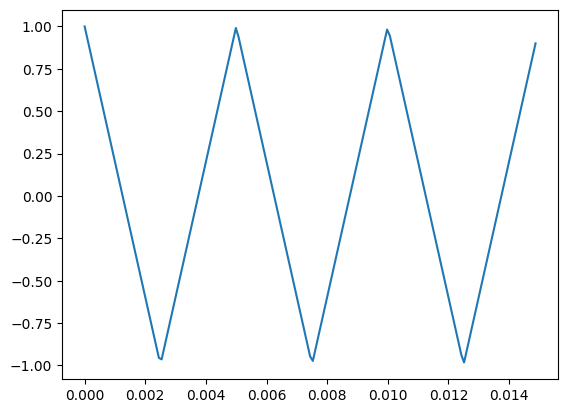

In [2]:
signal = thinkdsp.TriangleSignal(200)
signal.plot()

接下来，我们可以用这个信号来产生波形对象，然后再生成它的频谱:
> Next we can use the Signal to make a Wave, and use the Wave to make a Spectrum:

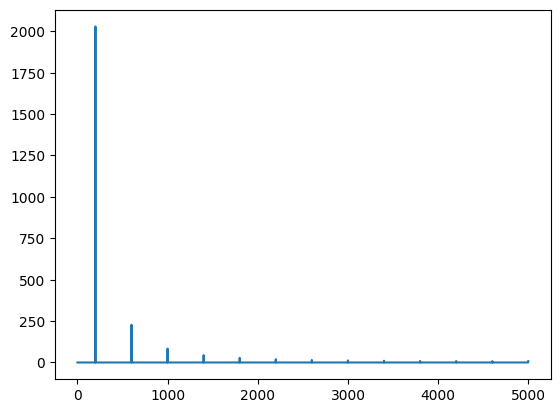

In [3]:
wave = signal.make_wave(duration=0.5, framerate=10000)
spectrum = wave.make_spectrum()
spectrum.plot()

图2.2 显示了频谱图，右面的图在Y轴上进行了放大，这样可以更清晰的显示谐波结构。 像我们期望的那样，基频200Hz的幅值是最大的，其它谐波频率分量的峰值出现在200Hz的整数倍频率上。
> Figure 2.2 shows two views of the result; the view on the right is scaled to show the harmonics more clearly. As expected, the highest peak is at the fundamental frequency, 200 Hz, and there are additional peaks at harmonic frequencies, which are integer multiples of 200.

![图2.2](figs/thinkdsp007.png)

有一个奇怪的现象是：谐波里面没有基频的偶数倍的频率（400Hz，800Hz等）， 而只有奇数倍的频率（600Hz，1000Hz，1400Hz等）。
> But one surprise is that there are no peaks at the even multiples: 400, 800, etc. The harmonics of a triangle wave are all odd multiples of the fundamental frequency, in this example 600, 1000, 1400, etc.

这些频率成分的另一个特性是，随着谐波频率的增加，幅度的减弱与频率的平方大致呈比例的关系。 例如，600Hz的谐波是基频200Hz的3倍，他的幅度和基频的比例大约是9倍的关系（3的平方）。 而1000Hz的谐波是600Hz的1.7倍左右，他们的幅度之比大概是 $1.7^2=2.9$ 。 我们把这种关系就称为信号的 谐波结构 。
> Another feature of this spectrum is the relationship between the amplitude and frequency of the harmonics. Their amplitude drops off in proportion to frequency squared. For example the frequency ratio of the first two harmonics (200 and 600 Hz) is 3, and the amplitude ratio is approximately 9. The frequency ratio of the next two harmonics (600 and 1000 Hz) is 1.7, and the amplitude ratio is approximately 1.72 = 2.9. This relationship is called the harmonic structure.

## 2.2 方波 Square waves

thinkdsp 还提供了 SquareSignal 类来表示方波信号，这个类的定义如下:
> thinkdsp also provides SquareSignal, which represents a square signal. Here’s the class definition:

```
def evaluate(self, ts):
    cycles = self.freq * ts + self.offset / PI2
    frac, _ = np.modf(cycles)
    ys = self.amp * np.sign(unbias(frac))
    return ys
```

类似 TriangleSignal 和 SquareSignal 这样继承自 Sinusoid 的类， 他们的共同点是都具有相同的构造参数：频率，幅度，初始相位。
> Like TriangleSignal, SquareSignal inherits __init__ from Sinusoid, so it takes the same parameters.

SquareSignal 的 evaluate 方法也具有类似的结构。其中 ts 依然是采样时间序列， frac 是它的小数部分，它的值从0到1周期的变化。
> And the evaluate method is similar. Again, cycles is the number of cycles since the start time, and frac is the fractional part, which ramps from 0 to 1 each period.

unbias 将 frac 调整到-0.5~0.5，然后 np.sign 将结果的负值映射到-1，正值映射到1。 最后，乘以 amp 将信号的幅值调整到 -amp~amp 。
> unbias shifts frac so it ramps from -0.5 to 0.5, then np.sign maps the neg- ative values to -1 and the positive values to 1. Multiplying by amp yields a square wave that jumps between -amp and amp.

图2.3 显示了100Hz方波信号的三个周期， 图2.4 显示了它的频谱。
> Figure 2.3 shows three periods of a square wave with frequency 100 Hz, and Figure 2.4 shows its spectrum.

![图2.3：100Hz方波信号波形图](figs/thinkdsp008.png)

![图2.4：100Hz方波信号的频谱图](figs/thinkdsp009.png)

和三角波一样，方波同样只包含奇数倍的谐波频率，它们的峰值在300Hz，500Hz，700Hz等。 但是它们幅度的减弱要比三角波慢一些（不是平方的关系）。
> Like a triangle wave, the square wave contains only odd harmonics, which is why there are peaks at 300, 500, and 700 Hz, etc. But the amplitude of the harmonics drops off more slowly. Specifically, amplitude drops in proportion to frequency (not frequency squared).

在本章后面的练习题中，你可以看到一些其他的波形和它们的谐波结构。
> The exercises at the end of this chapter give you a chance to explore other waveforms and other harmonic structures.

## 2.3 混叠 Aliasing

> 坦白说，之前介绍的几个波形，都是我刻意挑选的，避免了比较的复杂的波形和频谱给大家带来困惑。 但是，接下来我会介绍一些比较复杂的情况。
I have a confession. I chose the examples in the previous section carefully to avoid showing you something confusing. But now it’s time to get confused.

图2.5 显示了一个1100Hz的三角信号在10KHz采样率下的频谱。右图是左图的放大后的图像，这样可以看的更清楚。
> Figure 2.5 shows the spectrum of a triangle wave at 1100 Hz, sampled at 10,000 frames per second. Again, the view on the right is scaled to show the harmonics.

![图2.5:](figs/thinkdsp010.png)
图2.5：显示了一个1100Hz的三角信号在10KHz采样率下的频谱。右图是左图的放大后的图像
> Spectrum of a triangle signal at 1100 Hz sampled at 10,000 frames per second. The view on the right is scaled to show the harmonics.

这个信号的谐波应该在3300Hz，5500Hz，7700Hz和9900Hz。图中可以看到我们期望的1100Hz和3300Hz的频率， 但是第三个峰值的频率是在4500Hz而不是5500Hz，第四个峰值的频率是在2300Hz而不是7700Hz，下一个峰值的频率 是100Hz而不是9900Hz，这是怎么回事呢？
> The harmonics of this wave should be at 3300, 5500, 7700, and 9900 Hz. In the figure, there are peaks at 1100 and 3300 Hz, as expected, but the third peak is at 4500, not 5500 Hz. The fourth peak is at 2300, not 7700 Hz. And if you look closely, the peak that should be at 9900 is actually at 100 Hz. What’s going on?

造成这个情况的原因是，在计算整个信号的波形的过程中，实际上是在采样点在对信号进行了离散化的处理，因此 在连续信号的各个采样点之间会丢失掉一些信息。对于低频的信号丢失的信息不多，因为同样的采样率下，频率低 的信号在一个周期内可以有更多的采样点。
> The problem is that when you evaluate the signal at discrete points in time, you lose information about what happened between samples. For low frequency components, that’s not a problem, because you have lots of samples per period.

但是如果你用10000Hz的采样率来采集5000Hz的信号，一个信号周期内就仅有两个采样点了。实际上两个采样点是足够的， 但是如果信号的频率再高一点，一个周期内采样点小于两个，那么就会产生问题了。
> But if you sample a signal at 5000 Hz with 10,000 frames per second, you only have two samples per period. That turns out to be enough, just barely, but if the frequency is higher, it’s not.

为了解释这个现象，让我们来看两个余弦信号（4500Hz和5500Hz），我们使用10000Hz的采样率来计算他们的波形:
> To see why, let’s generate cosine signals at 4500 and 5500 Hz, and sample them at 10,000 frames per second:

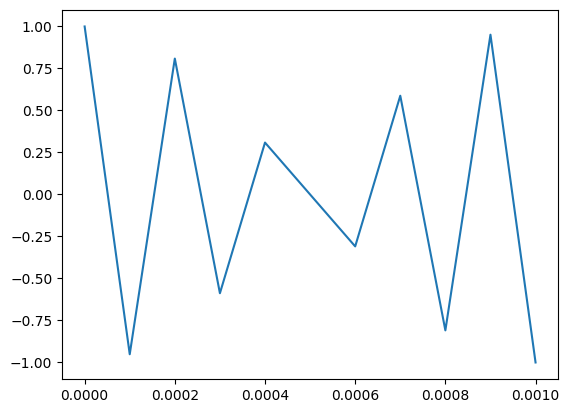

In [30]:
framerate = 10000

signal = thinkdsp.CosSignal(4500)
duration = signal.period*5
segment = signal.make_wave(duration, framerate=framerate)
segment.plot()

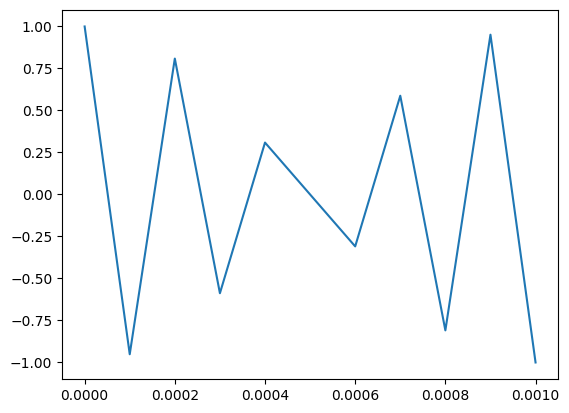

In [31]:
signal = thinkdsp.CosSignal(5500)
segment = signal.make_wave(duration, framerate=framerate)
segment.plot()

图2.6 中灰色的线是信号本身，而蓝色的竖线是采样后的信号。对比这两个图，可以发现， 两个不同的信号却产生了相同的采样值。
> Figure 2.6 shows the result. I plotted the Signals with thin gray lines and the samples using vertical lines, to make it easier to compare the two Waves. The problem should be clear: even though the Signals are different, the Waves are identical!

![图2.6 ](figs/thinkdsp011.png)

图2.6：10000Hz采样率下的4500Hz和5500Hz的余弦信号波形图
> Cosine signals at 4500 and 5500 Hz, sampled at 10,000 frames per second. The signals are different, but the samples are identical.

事实上，当我们用10000Hz采样率对5500Hz信号进行采样的时候，其结果与4500Hz的信号是相同的。 正是因为这样，7700Hz的信号和2300Hz的信号，9900Hz的信号和100Hz的信号在采样后也是相同的。
> When we sample a 5500 Hz signal at 10,000 frames per second, the result is indistinguishable from a 4500 Hz signal. For the same reason, a 7700 Hz signal is indistinguishable from 2300 Hz, and a 9900 Hz is indistinguishable from 100 Hz.

信号采样后产生的这种现象，我们就称为 混叠（aliasing） ，简单来说，就是高频信号采样后的与 某些特定的低频信号是无法区分出来的。
> This effect is called aliasing because when the high frequency signal is sampled, it appears to be a low frequency signal.

在这个例子中（10000Hz采样率），我们最高可以采集的频率为5000Hz，也就是采样率的一半，高于5000Hz的 频率成分会被折叠到5000Hz以内，因此我们把这个频率叫做折叠频率（floding frequence）， 又称为 奈奎斯特频率（Nyquist frequency） 。参见 http://en.wikipedia.org/wiki/Nyquist_frequency 。
> In this example, the highest frequency we can measure is 5000 Hz, which is half the sampling rate. Frequencies above 5000 Hz are folded back below 5000 Hz, which is why this threshold is sometimes called the “folding frequency”. It is sometimes also called the Nyquist frequency. See http://en.wikipedia.org/wiki/Nyquist_frequency.

我们可以这样来计算折叠后的频率：如果信号的频率大于采样率，通过对信号频率与采样率相除求余，来得到在0到采样率之间 的频率，然后如果这个频率大于折叠频率，则用采样率减去这个频率，最后就得到了折叠后的结果。 例如，之前波形的第五个 谐波频率是12100Hz，求余后为2100Hz，就是折叠后的频率了。你也可以从 图2.4 上看到这个2100Hz的频率。同样，也可以 看到4300Hz的频率（14300Hz，折叠后为4300Hz）。
> The folding pattern continues if the aliased frequency goes below zero. For example, the 5th harmonic of the 1100 Hz triangle wave is at 12,100 Hz. Folded at 5000 Hz, it would appear at -2100 Hz, but it gets folded again at 0 Hz, back to 2100 Hz. In fact, you can see a small peak at 2100 Hz in Figure 2.4, and the next one at 4300 Hz.

## 2.4 频谱的计算 Computing the spectrum

在之前的章节中，我们多次使用了 make_spectrum ，它的代码（省略了一些细节）是这样的:
> We have seen the Wave method make_spectrum several times. Here is the implementation (leaving out some details we’ll get to later):

```
from np.fft import rfft, rfftfreq

class Wave:
    def make_spectrum(self):
        n = len(self.ys)
        d = 1 / self.framerate

        hs = rfft(self.ys)
        fs = rfftfreq(n, d)

        return Spectrum(hs, fs, self.framerate)
```

self 参数代表的是波形对象本身， n 是波形的采样点数目， d 是采样率的倒数，也就是采样时间步长。
> The parameter self is a Wave object. n is the number of samples in the wave,
and d is the inverse of the frame rate, which is the time between samples.

np.fft 是Numpy提供的FFT方法（一种高效的计算DFT的算法）。
> np.fft is the NumPy module that provides functions related to the Fast Fourier Transform (FFT), which is an efficient algorithm that computes the Discrete Fourier Transform (DFT).

make_spectrum 使用了 rfft ，它的意思是“实数FFT”，如果信号是实数而不是复数，我们就可以使用它。 之后，我们会看到“完整FFT”，它可以处理复信号（见 7.9 ）。 rfft 的结果 hs 是一个复数的Numpy数组， 它表示了各个频率分量的复数幅值（幅度和初始相位另一种表示形式）。
> make_spectrum uses rfft, which stands for “real FFT”, because the Wave contains real values, not complex. Later we’ll see the full FFT, which can handle complex signals. The result of rfft, which I call hs, is a NumPy array of complex numbers that represents the amplitude and phase offset of each frequency component in the wave.

rfftfreq 的结果 fs 包含了与 hs 对应的频率值。
> The result of rfftfreq, which I call fs, is an array that contains frequencies corresponding to the hs.

对于 hs 中的复数，我们可以这样理解：
> To understand the values in hs, consider these two ways to think about com- plex numbers:

* 复数是实部和虚部的和，通常写成： 𝑥+𝑖𝑦 ，其中 𝑖 是单位虚数， 也就是 −1‾‾‾√。 我们可以把复数的x和y看做是复数在复平面下的坐标（以实轴为横坐标，虚轴为纵坐标的直角坐标系）
> A complex number is the sum of a real part and an imaginary part, often √written x + iy, where i is the imaginary unit, −1. You can think of x and y as Cartesian coordinates.
* 复数也可以表示为幅值和复指数的形式，写成： $𝐴^{𝑒𝑖𝜑}$ ，其中 𝐴 为模， 𝜑 为幅角。我们可以把它看做是复数在极坐标下的表示。
> A complex number is also the product of a magnitude and a complex exponential, Aeiφ, where A is the magnitude and φ is the angle in radians, also called the “argument”. You can think of A and φ as polar coordinates.
 
 
 
译者注

𝑥+𝑖𝑦
 的极坐标表示为： 𝐴cos(𝜑)+𝐴sin(𝜑)𝑖
 ， 根据欧拉公式 𝑒𝑖𝑥=cos(𝑥)+𝑖𝑠𝑖𝑛(𝑥)
 ，可以得出 𝐴𝑒𝑖𝜑

hs 中的每个复数就代表了该频率分量的复数幅值：它的模值就是该频率的幅度，它的幅角就是该频率的初始相位。
> Each value in hs corresponds to a frequency component: its magnitude is proportional to the amplitude of the corresponding component; its angle is the phase offset.

Spectrum 类中提供了两个只读的属性： amps 和 angles ， 用来得到这些幅值和初始相位（它们都被放在Numpy数组中）。 我们在画频谱图的时候，一般会画出相对于 fs 下的 amps ，或者相对于 fs 的 angles 。 在实际使用中，我们几乎不会直接去关注 hs 的实部和虚部。
> The Spectrum class provides two read-only properties, amps and angles, which return NumPy arrays representing the magnitudes and angles of the hs. When we plot a Spectrum object, we usually plot amps versus fs. Sometimes it is also useful to plot angles versus fs.

> Although it might be tempting to look at the real and imaginary parts of hs, you will almost never need to. I encourage you to think of the DFT as a vector of amplitudes and phase offsets that happen to be encoded in the form of complex numbers.

我们也可以直接通过改变 hs 的值来改变频谱，例如:
> To modify a Spectrum, you can access the hs directly. For example:

```
spectrum.hs *= 2
spectrum.hs[spectrum.fs > cutoff] = 0
```

第一行代码将 hs 中的元素乘了2, 相当于将所有谐波的幅值增加了2倍。 第二行代码将大于 cutoff 的频率分量的幅值设置到了0。
> The first line multiples the elements of hs by 2, which doubles the amplitudes of all components. The second line sets to 0 only the elements of hs where the corresponding frequency exceeds some cutoff frequency.

Spectrum 类中提供了简单的方法来完成这两个操作:
> But Spectrum also provides methods to perform these operations:

```
spectrum.scale(2)
spectrum.low_pass(cutoff)
```

你可以在 http://greenteapress.com/thinkdsp.html 上查看这些方法的文档说明。
> You can read the documentation of these methods and others at http://greenteapress.com/thinkdsp.html.

至此，你应该对 signal ， Wave 和 Spectrum 这几个类的工作方式有了比较清晰的了解， 但我们还没有解释FFT的原理，接下来的几章我们会慢慢的介绍。
> At this point you should have a better idea of how the Signal, Wave, and Spec- trum classes work, but I have not explained how the Fast Fourier Transform works. That will take a few more chapters.

## 2.5 练习 Exercises

下面练习的答案可以参考文件 chap02soln.ipynb 。
> Solutions to these exercises are in chap02soln.ipynb.

练习1 使用 Jupyter 打开 chap2.ipynb ，阅读并且运行上面的代码示例。 或者在 http://tinyurl.com/thinkdsp02 浏览和运行它。
> Exercise 2.1 If you use Jupyter, load chap02.ipynb and try out the examples. You can also view the notebook at http://tinyurl.com/thinkdsp02.

练习2 锯齿波的波形是周期性的从-1到1线性变化然后立即下降到-1再循环的一种信号， 详见 http://en.wikipedia.org/wiki/Sawtooth_wave 。
> Exercise 2.2 A sawtooth signal has a waveform that ramps up linearly from -1 to 1, then drops to -1 and repeats. See http://en.wikipedia.org/wiki/Sawtooth_wave

编写一个锯齿波的类，继承自 Signal ， 复写它的 evaluate 方法来生成锯齿信号。
> Write a class called SawtoothSignal that extends Signal and provides evaluate to evaluate a sawtooth signal.

计算出锯齿信号的频谱，看看它的谐波结构和方波，三角波有什么区别。
> Compute the spectrum of a sawtooth wave. How does the harmonic structure compare to triangle and square waves?

练习3 生成一个1100Hz的方波信号以及在10000Hz采样率下的波形，画出频谱图，可以看见大部分的谐波 被混叠了。那么当你听这个声音的时候，你能听到这些混叠后的频率吗？
> Exercise 2.3 Make a square signal at 1100 Hz and make a wave that samples it at 10000 frames per second. If you plot the spectrum, you can see that most of the harmonics are aliased. When you listen to the wave, can you hear the aliased harmonics?

练习4 生成任一个信号的频谱，把它的 fs 打印出来，你可以看到他们第一个值是0。 也就是说第一个频率分量是0Hz，这代表什么意义呢？
> Exercise 2.4 If you have a spectrum object, spectrum, and print the first few values of spectrum.fs, you’ll see that they start at zero. So spectrum.hs[0] is the magnitude of the component with frequency 0. But what does that mean?

试着做如下实验：
> Try this experiment:

* 生成一个440Hz的三角信号，生成并画出它0.01s的波形。
> Make a triangle signal with frequency 440 and make a Wave with dura- tion 0.01 seconds. Plot the waveform.
* 生成频谱并打印出 hs[0] ，看看他的幅值和初始相位是多少？
> Make a Spectrum object and print spectrum.hs[0]. What is the am- plitude and phase of this component?
* 设置 hs[0]=100 ，看看这样做会在波形上产生什么样的影响。 提示：频谱对象有一个 make_wave 方法可以生成对应的波形。
> Set spectrum.hs[0] = 100. Make a Wave from the modified Spectrum and plot it. What effect does this operation have on the waveform?

练习5 写一个函数，接受一个频谱对象作为参数，将 hs 中的每个元素除以 fs 中 对应的频率。提示：因为除以0是不可行的，你应该设置 hs[0]=0。
> Exercise 2.5 Write a function that takes a Spectrum as a parameter and modifies it by dividing each element of hs by the corresponding frequency from fs. Hint: since division by zero is undefined, you might want to set spectrum.hs[0] = 0.

用方波，三角波和锯齿波 来测试这个函数。
> Test your function using a square, triangle, or sawtooth wave.

* 画出原始的频谱图
> Compute the Spectrum and plot it.
* 调用你写的函数，并画出计算得到的频谱图
> Modify the Spectrum using your function and plot it again.
使用 make_wave 生成这个频谱的波形，并听听看产生了什么效果。
> Make a Wave from the modified Spectrum and listen to it. What effect does this operation have on the signal?

练习6 三角波和方波只有奇次谐波，锯齿波有奇次谐波也有偶次谐波。方波和锯齿波的谐波 按照 1𝑓 的规律衰减，而三角波的谐波是以 1𝑓2 的规律衰减。你能找到一个波形它包含奇次和偶次的谐波，并且它们是以 1𝑓2 的规律衰减吗？ 
> Exercise 2.6 Triangle and square waves have odd harmonics only; the saw- tooth wave has both even and odd harmonics. The harmonics of the square and sawtooth waves drop off in proportion to 1/f; the harmonics of the trian- gle wave drop off like 1/f2. Can you find a waveform that has even and odd harmonics that drop off like 1/f2?

提示：有两个方法可以完成这个任务，你可以通过将不同频率的正弦波相加来构造这个波形， 或者你也可以从一个类似的信号开始，然后改变它来生成想要的波形。
> Hint: There are two ways you could approach this: you could construct the signal you want by adding up sinusoids, or you could start with a signal that is similar to what you want and modify it.

[1]	使用下划线代表一个变量的时候，表示之后不会使用它，这是一个编码惯例。


## Waveforms and harmonics

Create a triangle signal and plot a 3 period segment.

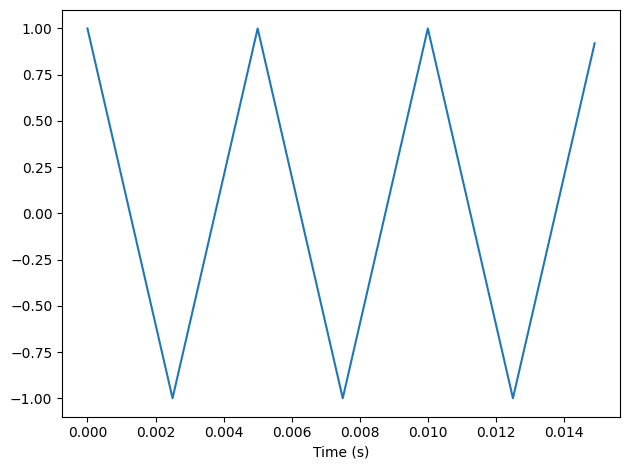

In [4]:
from thinkdsp import TriangleSignal
from thinkdsp import decorate

signal = TriangleSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [5]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

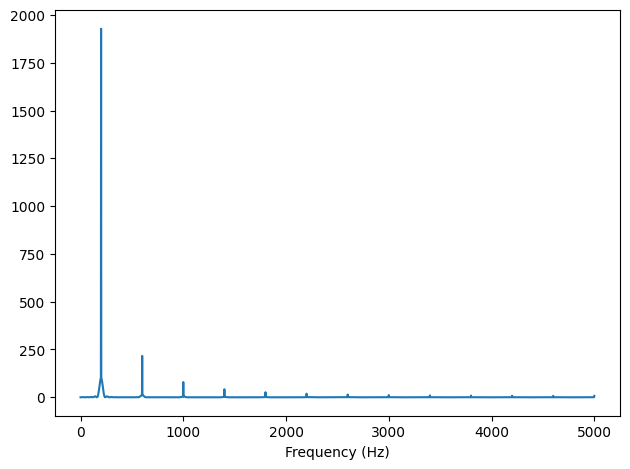

In [6]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Make a square signal and plot a 3 period segment.

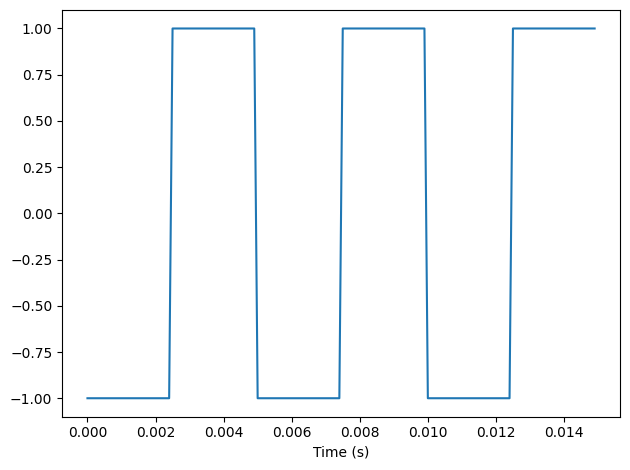

In [7]:
from thinkdsp import SquareSignal

signal = SquareSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [8]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

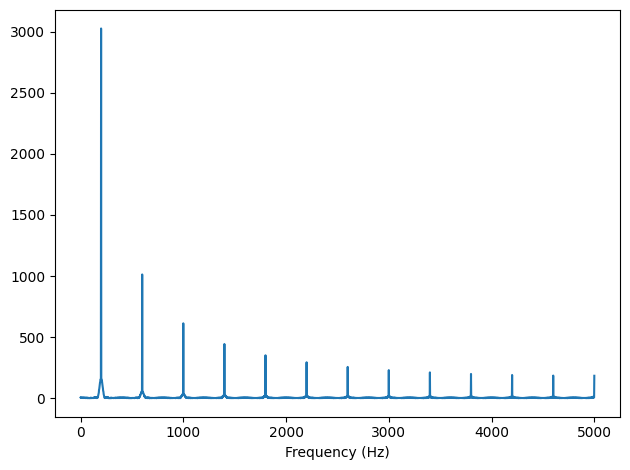

In [9]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Create a sawtooth signal and plot a 3 period segment.

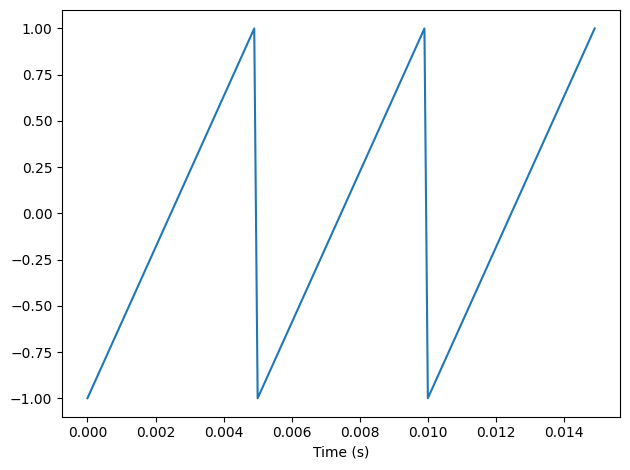

In [10]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [11]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

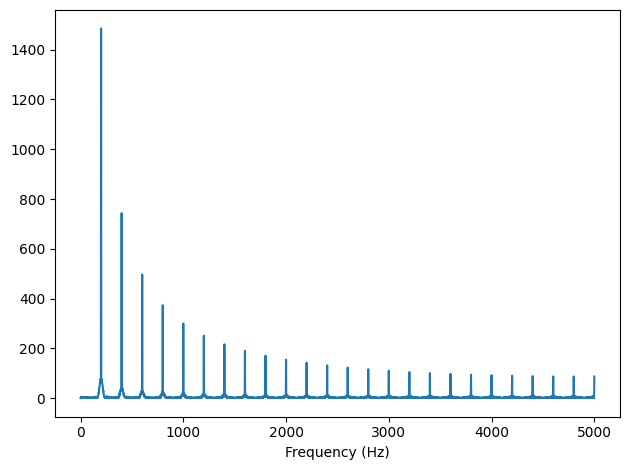

In [12]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

### Aliasing

Make a cosine signal at 4500 Hz, make a wave at framerate 10 kHz, and plot 5 periods.

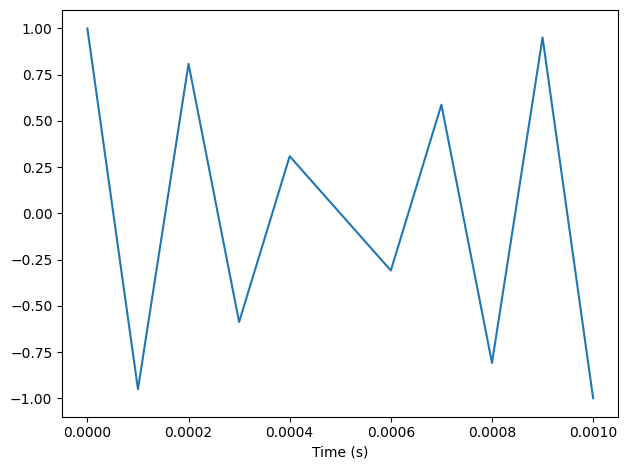

In [13]:
from thinkdsp import CosSignal

signal = CosSignal(4500)
duration = signal.period*5
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a cosine signal at 5500 Hz, make a wave at framerate 10 kHz, and plot the same duration.

With framerate 10 kHz, the folding frequency is 5 kHz, so a 4500 Hz signal and a 5500 Hz signal look exactly the same.

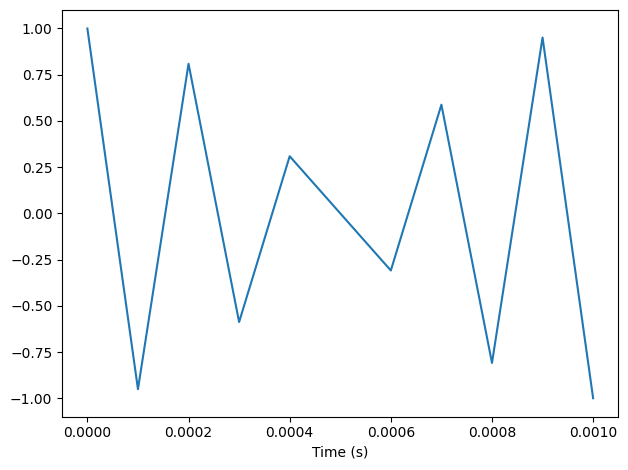

In [14]:
signal = CosSignal(5500)
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a triangle signal and plot the spectrum.  See how the harmonics get folded.

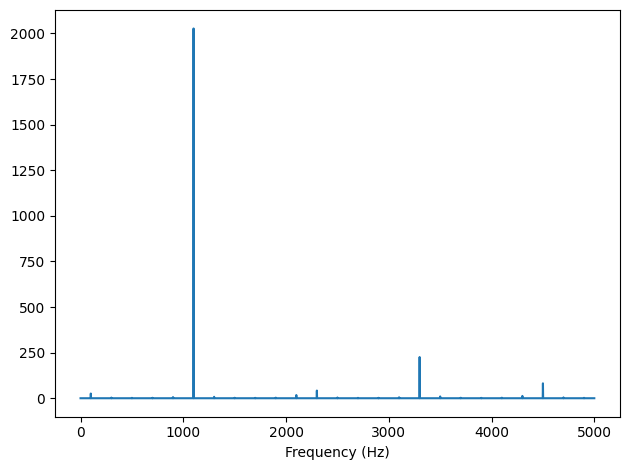

In [15]:
signal = TriangleSignal(1100)
segment = signal.make_wave(duration=0.5, framerate=10000)
spectrum = segment.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

## Amplitude and phase

Make a sawtooth wave.

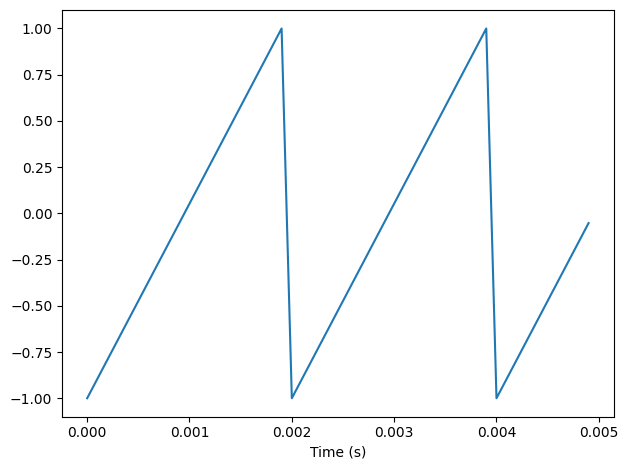

In [16]:
signal = SawtoothSignal(500)
wave = signal.make_wave(duration=1, framerate=10000)
segment = wave.segment(duration=0.005)
segment.plot()
decorate(xlabel='Time (s)')

Play it.

In [17]:
wave.make_audio()

Extract the wave array and compute the real FFT (which is just an FFT optimized for real inputs).

In [18]:
import numpy as np

hs = np.fft.rfft(wave.ys)
hs

array([ 5.11590770e-13+0.00000000e+00j,  2.19700679e-13-1.34559298e-13j,
       -2.09548671e-13-6.74603523e-14j, ...,
        4.19606174e-13+3.46000979e-14j, -5.63280756e-13+5.74915022e-14j,
       -5.26315789e+02+0.00000000e+00j])

Compute the frequencies that match up with the elements of the FFT.

In [19]:
n = len(wave.ys)                 # number of samples
d = 1 / wave.framerate           # time between samples
fs = np.fft.rfftfreq(n, d)
fs

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.998e+03, 4.999e+03,
       5.000e+03])

Plot the magnitudes vs the frequencies.

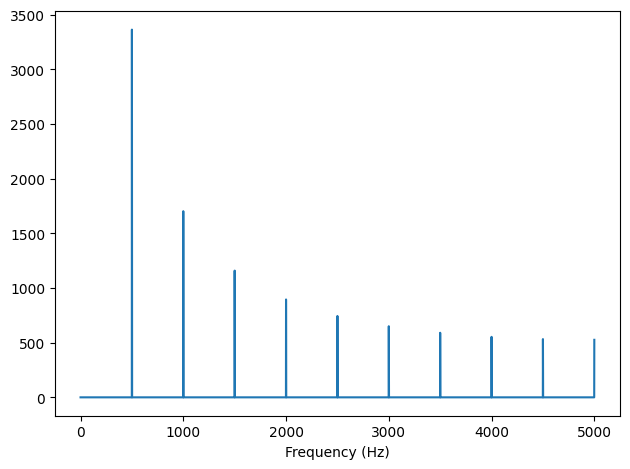

In [20]:
import matplotlib.pyplot as plt

magnitude = np.absolute(hs)
plt.plot(fs, magnitude)
decorate(xlabel='Frequency (Hz)')

Plot the phases vs the frequencies.

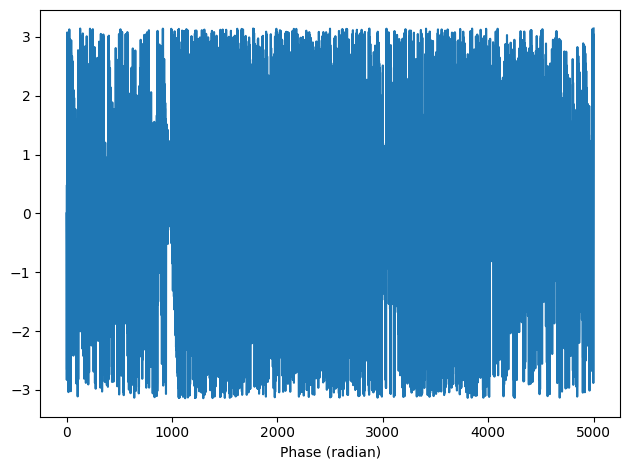

In [21]:
angle = np.angle(hs)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

## What does phase sound like?

Shuffle the phases.

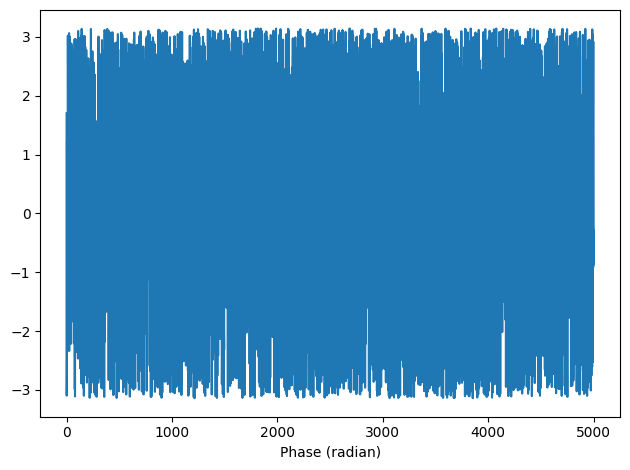

In [22]:
import random
random.shuffle(angle)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

Put the shuffled phases back into the spectrum.  Each element in `hs` is a complex number with magitude $A$ and phase $\phi$, with which we can compute $A e^{i \phi}$

In [23]:
i = complex(0, 1)
spectrum = wave.make_spectrum()
spectrum.hs = magnitude * np.exp(i * angle)

Convert the spectrum back to a wave (which uses irfft).

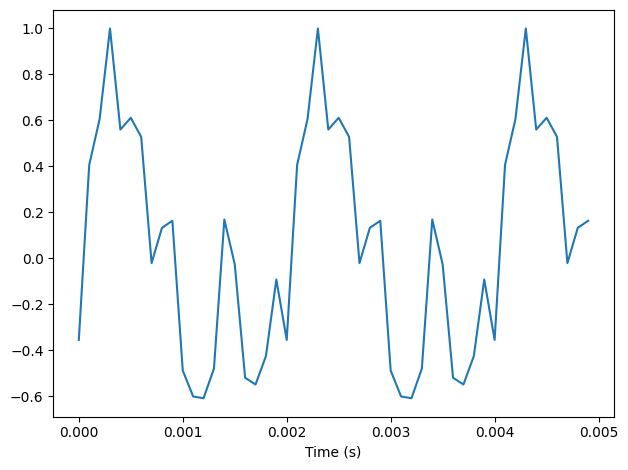

In [24]:
wave2 = spectrum.make_wave()
wave2.normalize()
segment = wave2.segment(duration=0.005)
segment.plot()
decorate(xlabel='Time (s)')

Play the wave with the shuffled phases.

In [25]:
wave2.make_audio()

For comparison, here's the original wave again.

In [26]:
wave.make_audio()

Although the two signals have different waveforms, they have the same frequency components with the same amplitudes.  They differ only in phase.

## Aliasing interaction

The following interaction explores the effect of aliasing on the harmonics of a sawtooth signal.

In [27]:
def view_harmonics(freq, framerate):
    """Plot the spectrum of a sawtooth signal.
    
    freq: frequency in Hz
    framerate: in frames/second
    """
    signal = SawtoothSignal(freq)
    wave = signal.make_wave(duration=0.5, framerate=framerate)
    spectrum = wave.make_spectrum()
    spectrum.plot(color='C0')
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')
    display(wave.make_audio())

In [28]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider1 = widgets.FloatSlider(min=100, max=10000, value=100, step=100)
slider2 = widgets.FloatSlider(min=5000, max=40000, value=10000, step=1000)
interact(view_harmonics, freq=slider1, framerate=slider2);

interactive(children=(FloatSlider(value=100.0, description='freq', max=10000.0, min=100.0, step=100.0), FloatS…